In [23]:
include("../src/AutomaticDifferention.jl")
include("../src/DataTransformationUtils.jl")

using .DataTransformationUtils
using .AutomaticDifferention
using Flux:glorot_uniform
using Random, Plots

In [24]:
function load_data(batch_size)
    printstyled("Loading data...\n", color = :yellow)
    xt, yt = DataTransformationUtils.prepare_and_encode(:train; one_hot = true)
    train_x_batched = DataTransformationUtils.batch_data(xt, batch_size)
    train_y_batched = DataTransformationUtils.batch_data(yt, batch_size)
    xv, yv = DataTransformationUtils.prepare_and_encode(:test; one_hot = true)
    return xt, yt, train_x_batched, train_y_batched, xv, yv
end

load_data (generic function with 1 method)

In [37]:
function train_network(epochs,batch_size)
    xt, yt, xt_batched, yt_batched, xv, yv = load_data(batch_size)

    # Input

    x = AutomaticDifferention.Variable([0.], name="x")

    # Dense Layer

    wd = AutomaticDifferention.Variable(glorot_uniform(10, 64))
    bd = AutomaticDifferention.Variable(glorot_uniform(10, ))
    fd = AutomaticDifferention.Constant(x -> x)
    dfd = AutomaticDifferention.Constant(x -> ones(size(x)))

    # RNN Layer

    wr = AutomaticDifferention.Variable(glorot_uniform(64, 196))
    br = AutomaticDifferention.Variable(glorot_uniform(64, ))
    u = AutomaticDifferention.Variable(glorot_uniform(64, 64))
    states = AutomaticDifferention.Variable(nothing, name = "hstates")
    fr = AutomaticDifferention.Constant(tanh)
    dfr = AutomaticDifferention.Constant(AutomaticDifferention.tanh_derivative)

    optimizer = AutomaticDifferention.Descent(10e-3)

    vanilla_rnn = AutomaticDifferention.vanilla_rnn(x, wr, br, u, states, fr, dfr)
    dense = AutomaticDifferention.dense(vanilla_rnn, wd, bd, fd, dfd)
    ordered_computation_graph = AutomaticDifferention.topological_sort(dense)
    
    batch_loss = Float64[]
    batch_acc = Float64[]

    printstyled("Training...\n", color = :yellow)
    for epoch in 1:epochs
        batches = randperm(size(xt_batched, 1))
        @time for batch in batches
            states.output = nothing
            x.output = xt_batched[batch][1:196,:]
            AutomaticDifferention.forward!(ordered_computation_graph)

            x.output = xt_batched[batch][197:392,:]
            AutomaticDifferention.forward!(ordered_computation_graph)

            x.output = xt_batched[batch][393:588,:]
            AutomaticDifferention.forward!(ordered_computation_graph)

            x.output = xt_batched[batch][589:end,:]
            result = AutomaticDifferention.forward!(ordered_computation_graph)

            loss = AutomaticDifferention.loss(result, yt_batched[batch])
            acc = DataTransformationUtils.accuracy(result, yt_batched[batch])

            push!(batch_loss, loss)
            push!(batch_acc, acc)

            gradient = AutomaticDifferention.softmax_crossentropy_gradient(result, yt_batched[batch]) ./ batch_size
            AutomaticDifferention.backward!(ordered_computation_graph, seed=gradient)
            AutomaticDifferention.update_weights!(ordered_computation_graph, optimizer)
        end
        states.output = nothing
        test_graph = AutomaticDifferention.topological_sort(dense)

        x.output = xv[  1:196,:]
        AutomaticDifferention.forward!(test_graph)

        x.output = xv[197:392,:]
        AutomaticDifferention.forward!(test_graph)

        x.output = xv[393:588,:]
        AutomaticDifferention.forward!(test_graph)

        x.output = xv[589:end,:]
        result = AutomaticDifferention.forward!(test_graph)

        loss = AutomaticDifferention.loss(result, yv)
        acc = DataTransformationUtils.accuracy(result, yv)

        @show epoch loss acc
    end
    return batch_loss, batch_acc
end

train_network (generic function with 1 method)

In [47]:
batch_loss, batch_acc = train_network(6, 100)

Loading data...
Training...
  1.057982 seconds (310.21 k allocations: 2.185 GiB, 13.33% gc time)
epoch = 1
loss = 1.4478139f0
acc = 58.99
  0.690209 seconds (310.20 k allocations: 2.185 GiB, 1.78% gc time)
epoch = 2
loss = 0.9720459f0
acc = 71.69
  0.714385 seconds (310.20 k allocations: 2.185 GiB, 1.69% gc time)
epoch = 3
loss = 0.8133172f0
acc = 75.81
  0.744356 seconds (310.20 k allocations: 2.185 GiB, 1.74% gc time)
epoch = 4
loss = 0.7303438f0
acc = 78.37
  0.720927 seconds (310.20 k allocations: 2.185 GiB, 1.72% gc time)
epoch = 5
loss = 0.6711805f0
acc = 80.85
  0.709325 seconds (310.20 k allocations: 2.185 GiB, 1.70% gc time)
epoch = 6
loss = 0.6253562f0
acc = 82.07


([2.4818222522735596, 2.7639760971069336, 2.6291561126708984, 2.64463472366333, 2.601794481277466, 2.639996290206909, 2.639375925064087, 2.5900750160217285, 2.518164873123169, 2.5459394454956055  …  0.7381283640861511, 0.814848005771637, 0.7209516167640686, 0.6866593360900879, 0.6508007049560547, 0.5326416492462158, 0.8565336465835571, 0.6935402154922485, 0.5797314643859863, 0.6577834486961365], [11.0, 6.0, 6.0, 10.0, 9.0, 8.0, 7.0, 7.0, 12.0, 11.0  …  71.0, 76.0, 82.0, 76.0, 77.0, 84.0, 81.0, 82.0, 83.0, 77.0])

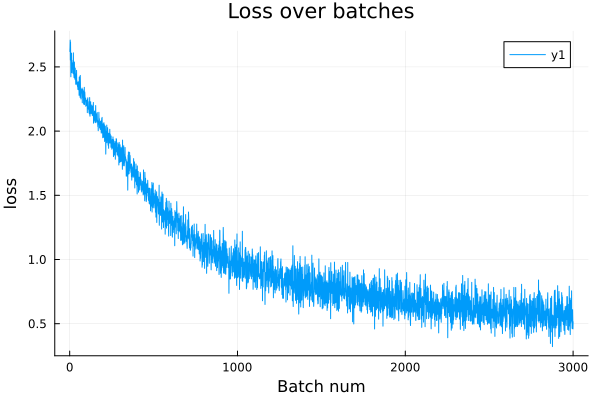

In [27]:
plot(batch_loss, xlabel="Batch num", ylabel="loss", title="Loss over batches")

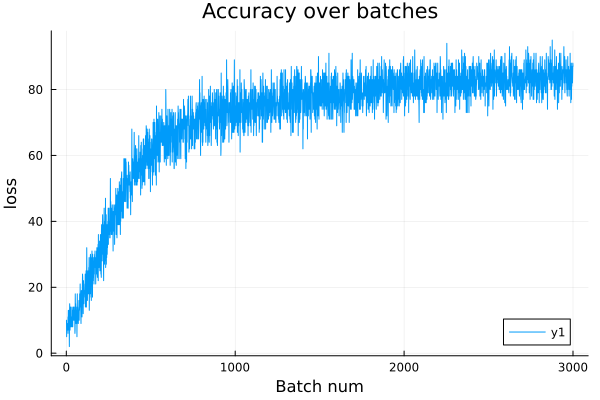

In [28]:
plot(batch_acc, xlabel="Batch num", ylabel="loss", title="Accuracy over batches")